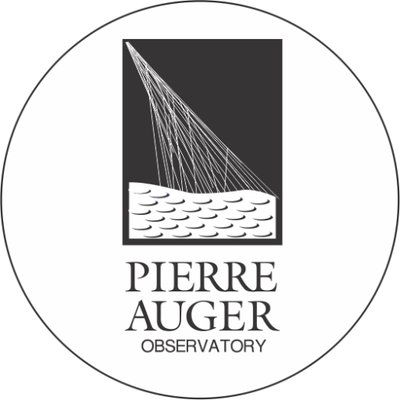
#  Analysis of $X_\mathrm{max}$ Measurements from the Fluorescence Detector of the Pierre Auger Observatory

<i>Notebook released together with the Pierre Auger Observatory Open Data release (<a href="https://doi.org/10.5281/zenodo.10488964">DOI 10.5281/zenodo.10488964</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

$X_\mathrm{max}$ is the atmospheric depth at which the number of particles in an air shower reaches its maximum. It is the best measured shower observable that is correlated with the composition of the primary cosmic ray composition. $X_\mathrm{max}$ is directly measured with the fluorescence detectors of the Pierre Auger Observatory by observing the longitudinal development of the air shower.

 Lighter primaries penetrate deeper in the atmosphere than heavier primaries. This is because heavier primaries are to good approximation a superposition of many less energetic light primaries. Therefore, heavier elements dissipate their energy faster and do not have the energy to penetrate deeper in the atmosphere. 
 
 The aim of this analysis is to sample the $X_\mathrm{max}$ distribution and the corresponding first two moments to estimate the composition. This is achieved by comparing the observations with predictions from high energy hadronic interaction models.  This notebook will show the different steps towards the calculation of the first two  moments of the $X_\mathrm{max}$ distribution, the mean and standard deviation ($\langle X_\mathrm{max}\rangle$ and $\sigma(X_\mathrm{max})$).
 
NOTE: this is a **simplified version** of the $X_\mathrm{max}$ analysis applied to data from the Pierre Auger Observatory. The sampled $X_\mathrm{max}$ distributions are affected by the detector resolution and by the detector $X_\mathrm{max}$ acceptance. Both effects need to be estimated and corrected for a precise  estimation of the $X_\mathrm{max}$ moments. Here we will only show an approximate analysis for the mean shower maximum. Due to the fiducial event selection, this analysis agrees with the final one within a few g/cm$^2$. We also present the raw standard deviation of $X_\mathrm{max}$ without correction for the detector resolution and acceptance and show the resolution-corrected fluctuations. For how to proceed for a full analysis and correction for detector effects, please refer to [Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612). 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
import scipy.stats
from IPython.display import HTML
import numpy.polynomial.polynomial as poly
LegendFontSize=25
LabelFontSize= 25
TickFontSize= 25

In [2]:
# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

In [3]:
# Default values for plots
plt.rcParams["figure.figsize"] = [11, 6.94] # figure width and height
plt.rcParams["font.size"] = 20

## Read the data file and select events for $X_\mathrm{max}$ analysis 

In [4]:
file_path = '/mnt/c/Users/paolo/Desktop/LAVORO/data_files/XmaxData_ICRC2023.txt'

names = ['fd_avg_lgE', 'fd_avg_xmax']
cols = (2, 1)

unique_xmax_data = dict(zip(names, np.loadtxt(file_path, usecols=cols, unpack=True, dtype=float, skiprows=1)))
print('ICRC DATA DROPPED')

ICRC DATA DROPPED


## Defining the energy bins

 Below we define the energy bin ranges. We will use the same energy bin ranges as in [Phys. Rev. Lett. 104 (2010) 091101](https://inspirehep.net/literature/845300), i.e. a binning that was used in an early publication of $X_\text{max}$ with statistics comparable to this data release.

In [5]:
lge_max = np.amax(unique_xmax_data['fd_avg_lgE'])
Ebins = [17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 19.2, 19.4, 
         (int(lge_max*10)+1)/10.]
display(Latex(f'The maximum energy in this data set is lg(E/eV) = {lge_max:7.2f}.'))

<IPython.core.display.Latex object>

## The $X_\mathrm{max}$ distributions and the $X_\mathrm{max}$ moments
 

In [6]:
# look into numpyification
def GetRawXmaxMoments(Ebins,lgEList,XmaxList):
    """
    Stores the list of Xmax values for each energy bin.
    Calculates the raw Xmax moments and their errors.
    Conveniently organize all the data in a Dictionary called 'Moments'.

    'Moments' is a dictionary that contains for each energy bin:
     
   * A list of Xmax values
   * Xmax moments and their errors (without correcting for the Xmax acceptance or resolution)
   * number of events
   * mean energy
   * systematic uncertainties
   
    """
    
    MeanXmaxList = []
    SigmaList = []
    MeanXmaxErrList = []
    SigmaErrList = []
    MeanLgEList = []
    NevtsList = []
    XmaxDistList = []
  
    
    for E1, E2 in zip(Ebins[:-1], Ebins[1:]): 
        ECut = (E1 <= lgEList) & (lgEList < E2)
        
        lgEmean = lgEList[ECut].mean() 
        Nevts = len(lgEList[ECut])

        XmaxMean = np.mean(XmaxList[ECut])
        SigmaXmax = np.std(XmaxList[ECut])
        MeanErr =  SigmaXmax / np.sqrt(Nevts)
        
        # uncertainty of the standard deviation
        # (Gaussian approximation, a more accurate estimate uses the fourth
        # central moment, see Particle Data Group)
        SigmaErr = SigmaXmax / np.sqrt(2*Nevts)
        
        MeanLgEList.append(lgEmean)
        NevtsList.append(Nevts)
        
        XmaxDistList.append(XmaxList[ECut])
        
        MeanXmaxList.append(XmaxMean)
        SigmaList.append(SigmaXmax)
        MeanXmaxErrList.append(MeanErr)
        SigmaErrList.append(SigmaErr)
        
    Moments = {'raw':{'mean': np.asanyarray(MeanXmaxList), 
                      'meanErr': np.asanyarray(MeanXmaxErrList),
                      'sigma': np.asanyarray(SigmaList),
                      'sigmaErr': np.asanyarray(SigmaErrList),
                      'Emean': np.asanyarray(MeanLgEList),
                      'Nevts': np.asanyarray(NevtsList)
                     },
               'distributions': XmaxDistList
              }
        
    return Moments

In [7]:
Moments = GetRawXmaxMoments(Ebins,unique_xmax_data['fd_avg_lgE'],unique_xmax_data['fd_avg_xmax'])

## Correcting for the $X_\mathrm{max}$ resolution

To convert $\sigma_\mathrm{raw}(X_\text{max})$ to the actual $\sigma(X_\text{max})$, it is necessary to take into account the total reconstruction resolution of $X_\mathrm{max}$.

The total reconstruction resolution of $X_\mathrm{max}$ has been parametrized as a function of energy:

* Coefficients for the $X_\mathrm{max}$ resolution parametrization ([Section VI-D in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) )

The $X_\mathrm{max}$ resolution make the $\sigma(X_\text{max})$ wider. In order to correct for this effect, the $X_\mathrm{max}$  resolution is subtracted in quadrature from $\sigma_\mathrm{raw}(X_\text{max})$.

In [8]:
resolution = pd.read_csv('/mnt/c/Users/paolo/Desktop/LAVORO/data_files/auxiliary/fdXmaxResolution.csv')


 GetXmaxResolution(resolution): 
 
 The parameters from the auxiliary file 'fdXmaxResolution.csv' are used to define the $X_\mathrm{max}$ resolution for each energy bin as defined at [Section VI-D in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) .
 
 GetXmaxResoFunc(resolution):
 
 A fit to the $X_\mathrm{max}$ resolution as function of energy is performed to obtain a function that returns the $X_\mathrm{max}$ resolution for any value of energy. This function will be used to have more flexibility in the definition of the energy bins. This means that we don't need to use the same energy bin definition as in [Section VI-D in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) . 

In [9]:
# needs numpyification
def GetXmaxResolution(resolution):
    """"
    Reads the coefficients for the Xmax resolution parametrization at each energy bin
    and calculates the resolution for each energy bin. It also calculates the uncertainty
    bands for the resolution.
    
    """
    ResoList = []
    ResoPlus = []
    ResoMinus = []
    EnBin = np.asanyarray(resolution['lgMinEnergy']) + 0.05 
    
    for ii, Ebin in enumerate(EnBin):
        k = resolution['f'][ii]
        sigma1 = resolution['sigma1'][ii]
        sigma2 = resolution['sigma2'][ii]
        V = k * sigma1*sigma1 + (1 - k) * sigma2*sigma2
        reso = np.sqrt(V)
        
        sigma1Err = resolution['sigma1Err'][ii]
        sigma2Err = resolution['sigma2Err'][ii]
        
        V_plus = k * (sigma1+sigma1Err)*(sigma1+sigma1Err) + \
            (1 - k) * (sigma2+sigma2Err)*(sigma2+sigma2Err) 
        reso_plus = np.sqrt(V_plus)
        
        V_minus = k * (sigma1-sigma1Err)*(sigma1-sigma1Err) + \
            (1 - k) * (sigma2-sigma2Err)*(sigma2-sigma2Err) 
        reso_minus=np.sqrt(V_minus)
        
        
        ResoList.append(reso)
        ResoPlus.append(reso_plus)
        ResoMinus.append(reso_minus)
    return [np.asanyarray(ResoList),  np.asanyarray(ResoPlus),
            np.asanyarray(ResoMinus), EnBin]

def GetXmaxResoFunc(resolution):
    """ Fits a function to the Xmax resolution Vs energy """
    ResoList = GetXmaxResolution(resolution)
    Ebins = ResoList[3]
    Reso = ResoList[0]
    x = np.asanyarray(Ebins)
    x = x.tolist()
    x.append(20)
    y = Reso
    y = y.tolist()
    y.append(Reso[-1])
    y = np.asanyarray(y)
    z = np.polyfit(x, y, 4)
    z = z[::-1]
    ResoFunc = poly.Polynomial(z)
    return ResoFunc


In [10]:
version = 'raw'

def CorrectForResolution(MomentsDict, ResoFunc):
    """ The Xmax resolution is substracted in quadrature from the raw sigma(Xmax) """
    
    lgE = MomentsDict['raw']['Emean']
    xmaxReso = ResoFunc(lgE)
    sigma = MomentsDict['raw']['sigma']
    sigmaErr = MomentsDict['raw']['sigmaErr']
    sigmaCorrected = np.sqrt(sigma*sigma - xmaxReso*xmaxReso)
    MomentsDict[version]['sigmaCorrected'] = sigmaCorrected
    # error propgation for sigmaCorrected
    MomentsDict[version]['sigmaCorrectedErr'] = sigmaErr/sigmaCorrected*sigma
    return MomentsDict

In [11]:
ResoFunc = GetXmaxResoFunc(resolution)
Moments = CorrectForResolution(Moments, ResoFunc)

## Load systematic uncertainty parameterizations for display

In [12]:
# Parametrizations that define the Xmax systematic uncertainties according to:
#  Phys. Rev. D 90, 122005 (2014)

def GetXmaxSystPRD2014plus(logE):
    p = [-2.36491238e-01,   1.45720450e+01,  -2.95795729e+02,   1.98962627e+03]
    p.reverse()
    GetSystPlus = poly.Polynomial(p)
    return GetSystPlus(logE)

def GetXmaxSystPRD2014minus(logE):
    p =[ -1.66409503e+00,   9.34458055e+01,  -1.74598689e+03,   1.08461078e+04]
    p.reverse()
    GetSystMinus = poly.Polynomial(p)
    return -GetSystMinus(logE)


def GetSigmaSystPRD2014plus(logE):
    p = [  1.82312628e+00,  -1.02328993e+02,   1.91290162e+03,  -1.19078859e+04]
    p.reverse()
    GetSystPlus = poly.Polynomial(p)
    return GetSystPlus(logE)

def GetSigmaSystPRD2014minus(logE):
    p = [ -1.23332547e+00,   6.91907431e+01,  -1.29288430e+03,   8.04495403e+03]
    p.reverse()
    GetSystPlus = poly.Polynomial(p)
    return -GetSystPlus(logE)

MeanLgEList = Moments[version]['Emean']
Xmax_dataSystUp = GetXmaxSystPRD2014plus(MeanLgEList)
Xmax_dataSystDown = GetXmaxSystPRD2014plus(MeanLgEList)
Sigma_dataSystUp = GetSigmaSystPRD2014plus(MeanLgEList)
Sigma_dataSystDown = GetSigmaSystPRD2014plus(MeanLgEList)

Moments['raw']['meanSystUp'] = Xmax_dataSystUp 
Moments['raw']['meanSystDown'] = Xmax_dataSystDown 
Moments['raw']['sigmaSystUp'] = Sigma_dataSystUp 
Moments['raw']['sigmaSystDown'] = Sigma_dataSystDown 

## Comparing observed $X_\mathrm{max}$ moments with model expectations for proton and Iron

In [13]:
# Functions related to the expected $X_\mathrm{max}$ moments according to the different models

def RailsFunc(lgE, p):
    x = lgE
    Rail = p[0] + p[1]*(x-18.) + p[2]*(x-18.)*(x-18.)
    return Rail


def GetModelRails():
    ModelTrails = {}
    
    ModelTrails['EPOS-LHC'] = {}
    ModelTrails['EPOS-LHC']['H'] = {}
    ModelTrails['EPOS-LHC']['H']['mean'] = [748.7824192267246, 57.72752933739214, -0.8492819413608501]
    ModelTrails['EPOS-LHC']['H']['sigma']= [ 60.754568341320265, -4.523514085098007, 1.3561246418133817]
    ModelTrails['EPOS-LHC']['Fe'] = {}
    ModelTrails['EPOS-LHC']['Fe']['mean'] = [648.6042870553292, 63.12370268046462, -1.971476995005652]
    ModelTrails['EPOS-LHC']['Fe']['sigma'] = [18.78185209432394, -1.5909852848013866, 0.3130051586485538]
    
    ModelTrails['QGSJetII-04'] = {}
    ModelTrails['QGSJetII-04']['H'] = {}
    ModelTrails['QGSJetII-04']['H']['mean'] = [733.3361855074645, 54.047662455592985, -0.16135288252029056]
    ModelTrails['QGSJetII-04']['H']['sigma'] = [64.14678054632051, -5.60721479996932, 1.0494756541917634]
    ModelTrails['QGSJetII-04']['Fe'] = {}
    ModelTrails['QGSJetII-04']['Fe']['mean'] = [635.9311237461296, 59.70402610426705, -1.9779302901269205]
    ModelTrails['QGSJetII-04']['Fe']['sigma'] = [23.662014632248354, -1.1934827895137259, -0.07813472862728368]
    
    ModelTrails['Sibyll2.3c'] = {}
    ModelTrails['Sibyll2.3c']['H'] = {}
    ModelTrails['Sibyll2.3c']['H']['mean'] = [761.9, 57.4, -8.07e-10]
    ModelTrails['Sibyll2.3c']['H']['sigma'] = [66.6, -5.7, 0.76] 
    ModelTrails['Sibyll2.3c']['Fe'] = {}
    ModelTrails['Sibyll2.3c']['Fe']['mean'] = [656.6, 60.1, -0.00016]
    ModelTrails['Sibyll2.3c']['Fe']['sigma'] = [ 24.51, -2.13, 0.2824]
    
    return ModelTrails


def PlotModelRails(moment, PlotLegend, BandW):
    ModelRails = GetModelRails()
    Models = ['EPOS-LHC','Sibyll2.3c','QGSJetII-04']
    Particles = ['H', 'Fe']
    ModelLines = ['','--','-.']
    if BandW == True:
        ParticleColors = ['black','black']
    else:
        ParticleColors = ['red','blue']
    Moments=['mean','sigma']
    #MEAN PLOT

    ModelPlot = {}
    ModelPlots = []

    # LegendFontSize = 25
    lgE = np.arange(17, 21, 0.1)
    for ii, model in enumerate(Models):
        for jj, Particle in enumerate (Particles):
            par = ModelRails[model][Particle][moment]
            plt.plot(lgE, RailsFunc(lgE,par), ModelLines[ii], color=ParticleColors[jj])
        ModelPlot[model], = plt.plot(lgE[0], [800], ModelLines[ii], color='black', label=model)
        ModelPlots.append(ModelPlot[model])

    if moment == 'mean':
        plt.text(19.4, 828, r'proton', verticalalignment='bottom', fontsize=LegendFontSize, rotation=21)
        plt.text(19.7, 735, r'iron', verticalalignment='bottom', fontsize=LegendFontSize, rotation=21)
        #plt.text(17.6, 819, '$\pm\;$ syst.', verticalalignment='center',horizontalalignment='left',fontsize=30, rotation=0)
        # Create a legend for the models.
    if PlotLegend:
        first_legend = plt.legend(handles=ModelPlots, loc=4, fontsize=LegendFontSize,
                                  numpoints=1,ncol=1, frameon=False,)
        if moment=='sigma':
            first_legend = plt.legend(handles=ModelPlots, loc=4, fontsize=LegendFontSize,
                                      numpoints=1, ncol=2, frameon=False,)
        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(first_legend)
    return

In [14]:
def PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW):
    lgE = Moments[mode]['Emean']

    LgEmin = 17.7
    LgEmax = 20.0
    
    
    SystFontSize = 15
    if (SetMoment == 'mean'):
        Mean = Moments[mode]['mean']
        StatErrDown = Moments[mode]['meanErr']
        StatErrUp = Moments[mode]['meanErr']
        SystPlus = Moments[mode]['meanSystUp']
        SystMinus = Moments[mode]['meanSystDown']

    if  (SetMoment == 'sigma'):
        Mean = Moments[mode]['sigmaCorrected']
        StatErrDown = Moments[mode]['sigmaCorrectedErr']
        StatErrUp = Moments[mode]['sigmaCorrectedErr']
        SystPlus = Moments[mode]['sigmaSystUp']
        SystMinus = Moments[mode]['sigmaSystDown']
        

    EcutSigma=25
    EnergyCut = lgE < 25
    if SetMoment == 'mean':
        plt.subplot(1,2,1)
        EnergyCut = lgE < 25
    if SetMoment == 'sigma':
        plt.subplot(1, 2, 2)
        SystPlus = SystPlus - 0.3
        SystMinus = SystMinus + 2.3
        EnergyCut = lgE < EcutSigma
    
    yErrors = [StatErrDown[EnergyCut], StatErrUp[EnergyCut]]
    
    data = plt.errorbar(lgE[EnergyCut], Mean[EnergyCut], yerr=yErrors, fmt='.',
                        color='black', marker='o',
                        fillstyle='full', markersize=8, capsize=0, label=Label)

    
    plt.minorticks_on()
    plt.tick_params('both', length=10, width=1, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')

    
    if (SetMoment == 'mean' or SetMoment == 'meanBoth'):
        plt.ylabel(r'$\langle X_\mathrm{max} \rangle$  $[\mathrm{g/cm^2}]$ ',
                   fontsize=LabelFontSize)
    if (SetMoment == 'sigma' or  SetMoment == 'sigmaBoth' ):
        plt.ylabel(r'$\sigma(\mathrm{X_{max}})$  $\mathrm{[g/cm^2]}$', 
                   fontsize=LabelFontSize)

    plt.xlabel(r'$\mathrm{lg(E/eV)}$', fontsize=LabelFontSize)
    plt.xticks(fontsize=TickFontSize)
    plt.yticks(fontsize=TickFontSize)
    plt.xlim(LgEmin, LgEmax)
    #plt.grid()
    
    PlotLegend=True
    if PlotModels:
        if (SetMoment == 'sigma' or  SetMoment == 'sigmaBoth'):
            PlotLegend = False
        if (SetMoment == 'sigmaBoth'):
            PlotModelRails('sigma', PlotLegend, BandW)
        if (SetMoment == 'meanBoth'):
            PlotModelRails('mean', PlotLegend, BandW)
        if (SetMoment == 'mean' or SetMoment == 'sigma'):
             PlotModelRails(SetMoment, PlotLegend, BandW)
            
    # Create another legend for the data.
    #if (SetMoment=='mean' or SetMoment=='meanBoth'):
    if Label:
        plt.legend(handles=[data], loc=2,fontsize=LegendFontSize, 
                   numpoints=1, ncol=1, frameon=False)


    if PlotSyst:
    #-------------(lgE,Mean,StatErr,SystPlus,SystMinus,PlotModels
        Xmax_dataSystUp = np.asanyarray(Mean + np.asanyarray(SystPlus))
        Xmax_dataSystDown = np.asanyarray(Mean - np.asanyarray(SystMinus))


        for ii, logE in enumerate(lgE):
            if ( SetMoment == 'sigma' or SetMoment == 'sigmaBoth'):
                if ( logE < EcutSigma):
                    plt.text(logE-0.01, Xmax_dataSystUp[ii], r'[', 
                             verticalalignment='center', horizontalalignment='center',
                             fontsize=15, rotation=-90, color='black')
                    plt.text(logE, Xmax_dataSystDown[ii] + 3, r'[', verticalalignment='center',
                             horizontalalignment='center', fontsize=15, rotation=90, color='black')
            else:
                plt.text(logE - 0.01, Xmax_dataSystUp[ii], r'[', verticalalignment='center',
                         horizontalalignment='center', fontsize=15, rotation=-90, color='black')
                plt.text(logE, Xmax_dataSystDown[ii] + 3, r'[', verticalalignment='center',
                         horizontalalignment='center', fontsize=15, rotation=90, color='black')
                
        if (SetMoment == 'mean' or SetMoment == 'meanBoth'):
            plt.text(LgEmin + 0.18, 820, r'[', verticalalignment='center',
                     horizontalalignment='center',fontsize=SystFontSize, 
                     rotation=90, color='black')
            plt.text(LgEmin + 0.175, 830, r'[', verticalalignment='center',
                     horizontalalignment='center', fontsize=SystFontSize, 
                     rotation=-90, color='black')
            plt.text(LgEmin + 0.27, 825, '$\pm\;$ syst.', verticalalignment='center',
                     horizontalalignment='left', fontsize=LegendFontSize, rotation=0)


    #---------------
    if TwinAxis:
        ax2 = plt.twiny()
        #ax2.set_xscale("log", nonposy='clip')
        ax2.set_xscale("log")
        ax2.errorbar([pow(10, 17.14), pow(10, 19.87)], [600, 850], yerr=0, fmt='.',
                     color='black', marker='o',
                     fillstyle='full', markersize=0, capsize=0, label='')

        ax2.set_xlabel('$\mathrm{E[eV]}$', fontsize=LabelFontSize)
        plt.minorticks_on()
        plt.tick_params('both', length=10, width=1, which='major')
        plt.tick_params('both', length=5, width=1, which='minor')

        plt.xticks(fontsize=TickFontSize)
        plt.yticks(fontsize=TickFontSize)
        ax2.set_xlim(pow(10, LgEmin), pow(10, LgEmax))
        
        
    if (SetMoment == 'mean' or SetMoment == 'meanBoth'):
        plt.ylim(570,870)
    if (SetMoment == 'sigma' or SetMoment == 'sigmaBoth'):
        plt.ylim(1, 79)

    return data

<>:105: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:105: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42303/48434760.py:105: SyntaxWarning: invalid escape sequence '\p'
  plt.text(LgEmin + 0.27, 825, '$\pm\;$ syst.', verticalalignment='center',
/tmp/ipykernel_42303/48434760.py:118: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('$\mathrm{E[eV]}$', fontsize=LabelFontSize)


In [15]:
def PlotER(Moments, mode, PlotSyst, PlotModels, Label, BandW):
    SetMoment = 'mean'
    TwinAxis = True
    plt.figure(num=None, figsize=(18, 9), dpi=60, facecolor='w', edgecolor='k')
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    return

/tmp/ipykernel_42303/477149288.py:11: RuntimeWarning: Mean of empty slice.
  y_means = np.array([dd['dnn_xmax'][bin_idx == i].mean() for i in range(n_bins)])
/home/magnani_3/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/magnani_3/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/magnani_3/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/magnani_3/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_42303/48434760.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argu

[1.00000000e+18 1.46779927e+18 2.15443469e+18 3.16227766e+18
 4.64158883e+18 6.81292069e+18 1.00000000e+19 1.46779927e+19
 2.15443469e+19 3.16227766e+19 4.64158883e+19 6.81292069e+19
 1.00000000e+20]
dict_keys(['dnn_axis', 'dnn_core', 'dnn_energy', 'dnn_xmax', 'event_id', 'auger_id', 'sd_id', 'is_saturated', 'core', 'axis', 'energy', 'xmax', 'element', 'mass', 'merit', 'fd_energy', 'fd_axis', 'sd_energy', 'sd_axis', 'sd_galactic_latitude', 'sd_galactic_longitude', 'sd_core', 'univ_energy', 'univ_axis', 'delta_mean_delta', 'delta_xmax', 'delta_energy', 'muon_number'])


/tmp/ipykernel_42303/48434760.py:114: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax2.errorbar([pow(10, 17.14), pow(10, 19.87)], [600, 850], yerr=0, fmt='.',


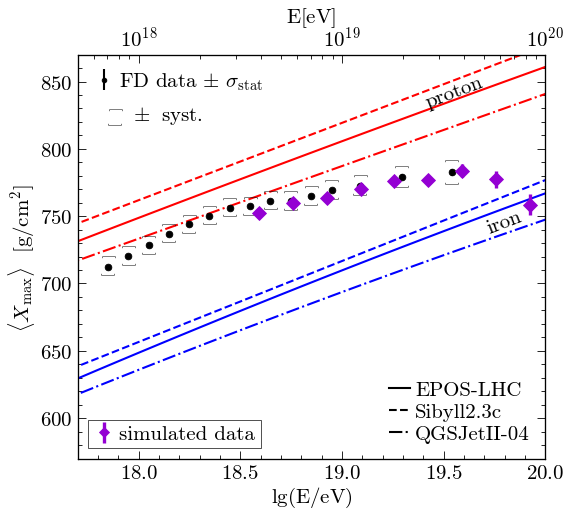

In [16]:
# can select to plot with/without:
#  w/o systematics, 
#  w/o model expectations for proton and iron and 
#  a selection of black and white or coloured plot
dd = np.load('simulated_data.npy', allow_pickle=True).item()
n_bins = 12 
bins = np.logspace(18, 20, n_bins+1)
print(bins)
bin_idx = np.digitize(dd['energy']*1e18, bins)-1
bin_centers = (bins[1:]+bins[:-1])/2
y_means = np.array([dd['dnn_xmax'][bin_idx == i].mean() for i in range(n_bins)])
y_std = np.array([dd['dnn_xmax'][bin_idx == i].std() for i in range(n_bins)])
n_points = np.array([np.sum(bin_idx == i) for i in range(n_bins)])
y_se = y_std / np.sqrt(n_points)

# hist, bin_edges = np.histogram(dd['energy'], bins=20, weights=dd['dnn_xmax'])
# hist_mean = hist/np.histogram(dd['energy'], bins=20)[0]
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

print(dd.keys())


PlotSyst = True
PlotModels = True
BlackAndWhite = False
MomentsType = 'raw'
DataLabel = r'FD data $\pm$ $\sigma_{\mathrm{stat}}$'

Label = DataLabel
PlotER(Moments, MomentsType, PlotSyst, PlotModels, Label, BlackAndWhite)
plt.errorbar(bin_centers, y_means, yerr=(y_std/np.sqrt(n_points)), ls='', marker='D', markersize=12, color='darkviolet', lw=4, label='simulated data')
plt.legend(loc='lower left', fontsize=LegendFontSize)
plt.tight_layout()

plt.show()


## Plotting the second $X_\mathrm{max}$ moment

In [17]:
def PlotSigma(Moments, mode, PlotSyst, PlotModels, Label, BandW):
    SetMoment = 'sigma'
    TwinAxis = True
    plt.figure(num=None, figsize=(18, 9), dpi=60, facecolor='w', edgecolor='k')
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    return

/tmp/ipykernel_42303/48434760.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  data = plt.errorbar(lgE[EnergyCut], Mean[EnergyCut], yerr=yErrors, fmt='.',
/tmp/ipykernel_42303/48434760.py:114: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax2.errorbar([pow(10, 17.14), pow(10, 19.87)], [600, 850], yerr=0, fmt='.',


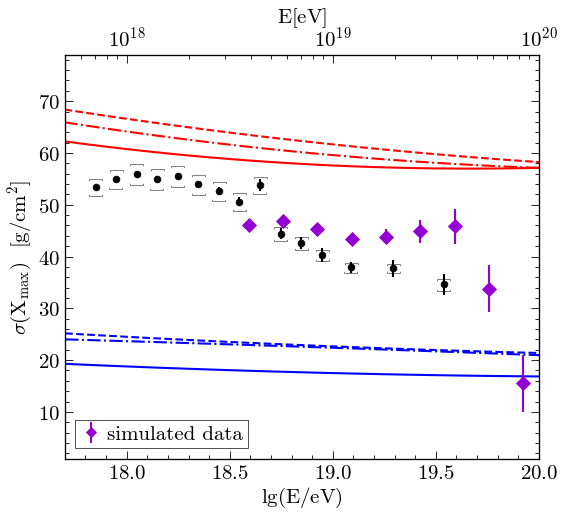

In [18]:
PlotSyst = True
PlotModels = True
BlackAndWhite = False
MomentsType = 'raw'
DataLabel = r'FD data $\pm$ $\sigma_{\mathrm{stat}}$'


Label = ''
PlotSigma(Moments, MomentsType, PlotSyst, PlotModels,
               Label, BlackAndWhite)
plt.errorbar(bin_centers, y_std, yerr=(y_std/np.sqrt(2*n_points)), ls='', marker='D', markersize=12, color='darkviolet', label='simulated data')
plt.legend(loc='lower left', fontsize=LegendFontSize)
plt.tight_layout()

plt.show()

## Plotting the first and second $X_\mathrm{max}$ moments

In [19]:
def PlotBothMoments(Moments, mode, PlotSyst, PlotModels, Label, BandW):
    SetMoment = 'mean'
    TwinAxis = True
    plt.figure(num=None, figsize=(18, 9), dpi=60, facecolor='w', edgecolor='k')
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    
    SetMoment = 'sigma'
    Label = ''
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    
    return

/tmp/ipykernel_42303/48434760.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  data = plt.errorbar(lgE[EnergyCut], Mean[EnergyCut], yerr=yErrors, fmt='.',
/tmp/ipykernel_42303/48434760.py:114: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax2.errorbar([pow(10, 17.14), pow(10, 19.87)], [600, 850], yerr=0, fmt='.',


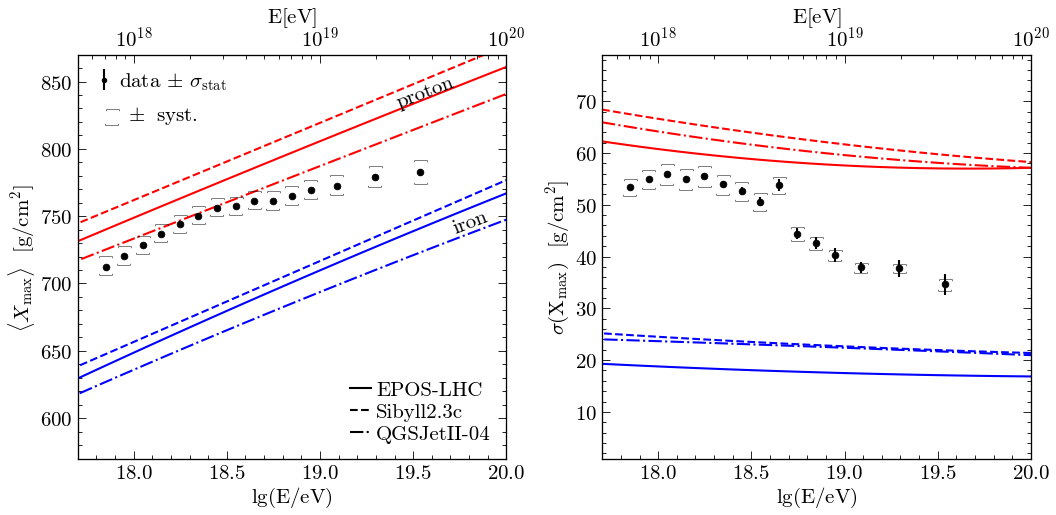

In [20]:
PlotSyst = True
PlotModels = True
XmaxCorrection = 0
SigmaCorrection = 0
BlackAndWhite = False
MomentsType = 'raw'
DataLabel = r'data $\pm$ $\sigma_{\mathrm{stat}}$'

Label = DataLabel
PlotBothMoments(Moments, MomentsType, PlotSyst, PlotModels,
              Label, BlackAndWhite)

plt.tight_layout()

plt.show()